### Week 3 - Segmenting and Clustering Neighborhoods in Toronto

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

import folium
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

#### Webscrape Canada's list of postal codes from its wikipedia page

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(url)

In [3]:
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')

In [4]:
content_table = []

for row in table.findAll('td'):
    cell = {}
    if row.span.text == 'Not assigned':
        pass
    else:
        cell['Postalcode'] = row.b.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /', ',')).replace(')', ' ')).strip(' ')
        content_table.append(cell)

In [5]:
df = pd.DataFrame(content_table)
df.head(11)

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [6]:
df['Borough'] = df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                      'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                      'EtobicokeNorthwest':'Etobivoke Northwest',
                                      'East YorkEast Toronto':'East York/East Toronto',
                                      'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [7]:
print('Shape of the dataframe {}'.format(df.shape))

Shape of the dataframe (103, 3)


#### Order the dataframe to match the "Geospatial_Coordinates.csv" file

In [8]:
order_df = df.sort_values(by=['Postalcode'], ascending = True)
order_df.reset_index(drop = True, inplace = True)
order_df.head(12)

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [9]:
coordinates_df = pd.read_csv('Geospatial_Coordinates.csv')
coordinates_df.reset_index(drop = True, inplace = True)

In [10]:
Toronto_df = pd.concat([order_df, coordinates_df], axis = 1)
Toronto_df.drop(['Postal Code'], axis = 1, inplace = True)
Toronto_df.head(12)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


#### Narrow my clustering task by looking at the overall count for each Borough

In [11]:
Toronto_df.groupby('Borough').count()

,Postalcode,Neighborhood,Latitude,Longitude
Borough,,,,
Central Toronto,9,9,9,9
Downtown Toronto,17,17,17,17
Downtown Toronto Stn A,1,1,1,1
East Toronto,4,4,4,4
East Toronto Business,1,1,1,1
East York,4,4,4,4
East York/East Toronto,1,1,1,1
Etobicoke,11,11,11,11
Etobivoke Northwest,1,1,1,1


#### Downtown Toronto was chosen for the clustering task

In [12]:
downtown_df = Toronto_df[Toronto_df['Borough'] == 'Downtown Toronto'].reset_index(drop = True)
downtown_df.head(17)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
5,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
6,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
7,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
9,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752


In [13]:
geolocator = Nominatim(user_agent = 'on_explorer')
location = geolocator.geocode('Downtown Toronto, ON')
latitude = location.latitude
longitude = location.longitude
print('Coordinates for Downtown Toronto are the following: {} / {}'.format(latitude, longitude))

Coordinates for Downtown Toronto are the following: 43.6563221 / -79.3809161


In [14]:
map_downtown = folium.Map(location = [latitude, longitude], zoom_start = 13)

for lat, lng, label in zip(downtown_df['Latitude'], downtown_df['Longitude'], downtown_df['Neighborhood']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng],
    radius = 4,
    popup = label,
    color = 'blue',
    fill = True,
    fill_color = '#3186cc',
    fill_opacity = 0.7,
    parse_html = False).add_to(map_downtown)
    
map_downtown

#### Initiate Foursquare to obtain nearby venues

In [15]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20200615'
LIMIT = 100

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    
    return nearby_venues

In [17]:
downtown_venues = getNearbyVenues(names = downtown_df['Neighborhood'], 
                                  latitudes = downtown_df['Latitude'],
                                  longitudes = downtown_df['Longitude'])

Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
First Canadian Place, Underground city
Christie


In [18]:
print(downtown_venues.shape)
downtown_venues.head(5)

(1089, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"St. James Town, Cabbagetown",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


In [19]:
print('There are {} uniques categories'.format(len(downtown_venues['Venue Category'].unique())))

There are 204 uniques categories


#### One hot encode the venues obtained for each neighborhood

In [20]:
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix = "", prefix_sep = "")

downtown_onehot['Neighborhood'] = downtown_venues['Neighborhood']

fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]
downtown_onehot.head(5)

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
downtown_grouped = downtown_onehot.groupby('Neighborhood').mean().reset_index()
downtown_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.017241,0.000000,0.0000,0.000000,0.000000,0.000000
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.066667,0.066667,0.133333,0.2,0.133333,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
2,Central Bay Street,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.016667,0.000000,0.0000,0.016667,0.000000,0.000000
3,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
4,Church and Wellesley,0.025641,0.012821,0.012821,0.000000,0.000000,0.000000,0.0,0.000000,0.012821,...,0.012821,0.012821,0.00,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
5,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.030000,...,0.000000,0.000000,0.00,0.00,0.020000,0.000000,0.0000,0.010000,0.000000,0.000000
6,"First Canadian Place, Underground city",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.030000,...,0.010000,0.000000,0.00,0.01,0.010000,0.000000,0.0000,0.010000,0.000000,0.000000
7,"Garden District, Ryerson",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.020000,0.000000,0.00,0.00,0.000000,0.000000,0.0100,0.010000,0.000000,0.000000
8,"Harbourfront East, Union Station, Toronto Islands",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.010000,0.000000,0.00,0.01,0.010000,0.000000,0.0000,0.010000,0.000000,0.000000
9,"Kensington Market, Chinatown, Grange Park",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.046875,0.000000,0.0625,0.015625,0.000000,0.015625


In [22]:
num_top_venues = 5

for hood in downtown_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = downtown_grouped[downtown_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.10
1  Cocktail Bar  0.07
2        Bakery  0.05
3      Pharmacy  0.03
4   Cheese Shop  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.20
1    Airport Lounge  0.13
2  Airport Terminal  0.13
3     Boat or Ferry  0.07
4   Harbor / Marina  0.07


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1                Café  0.07
2      Sandwich Place  0.05
3  Italian Restaurant  0.05
4     Thai Restaurant  0.03


----Christie----
           venue  freq
0  Grocery Store  0.27
1           Café  0.20
2           Park  0.13
3      Nightclub  0.07
4    Candy Store  0.07


----Church and Wellesley----
                 venue  freq
0          Coffee Shop  0.08
1     Sushi Restaurant  0.06
2  Japanese Restaurant  0.06
3           Restaurant  0.04
4              Gay Bar  0.04


----Commerce C

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Discover the most common venues at each neighborhood

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create new columns based on the number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = downtown_grouped['Neighborhood']

for ind in np.arange(downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Beer Bar,Farmers Market,Pharmacy,Restaurant,Cheese Shop,Seafood Restaurant,Basketball Stadium
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Bar,Boat or Ferry,Airport,Airport Food Court,Harbor / Marina,Rental Car Location,Sculpture Garden
2,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Japanese Restaurant,Thai Restaurant,Salad Place,Bank,Bubble Tea Shop
3,Christie,Grocery Store,Café,Park,Baby Store,Italian Restaurant,Candy Store,Nightclub,Coffee Shop,Restaurant,Dog Run
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Yoga Studio,Men's Store,Mediterranean Restaurant,Hotel,Fast Food Restaurant


#### Discover the best number to cluster Downtown Toronto

Text(0.5, 1.0, 'Elbow Method for discovering optimal cluster n')

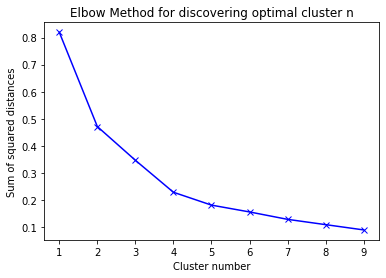

In [25]:
sum_of_squared_distances = []
kclusters = range(1,10)

downtown_grouped_clustering = downtown_grouped.drop('Neighborhood', 1)

for k in kclusters:
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(downtown_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(kclusters, sum_of_squared_distances, 'bx-')
plt.xlabel('Cluster number')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for discovering optimal cluster n')

#### Cluster each neighborhood based on their venues

In [26]:
n_cluster = 4
kmeans = KMeans(n_clusters = n_cluster, random_state = 0).fit(downtown_grouped_clustering)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
downtown_merged = downtown_df

downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
downtown_merged.head() 

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,3,Park,Playground,Trail,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
1,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,1,Coffee Shop,Restaurant,Pub,Café,Italian Restaurant,Bakery,Pizza Place,Park,Yoga Studio,Butcher
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Yoga Studio,Men's Store,Mediterranean Restaurant,Hotel,Fast Food Restaurant
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Park,Breakfast Spot,Restaurant,Pub,Café,Theater,Yoga Studio,Mexican Restaurant
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Bubble Tea Shop,Italian Restaurant,Japanese Restaurant,Hotel,Café,Cosmetics Shop,Electronics Store


#### Create a map showing each neighborhood's clustering label

In [29]:
downtown_map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 13)

# set color scheme for the clusters
x = np.arange(n_cluster)
ys = [i + x + (i*x)**2 for i in range(n_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['Latitude'], downtown_merged['Longitude'], downtown_merged['Neighborhood'], downtown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster)-1],
        fill = True,
        fill_color = rainbow[int(cluster)-1],
        fill_opacity = 0.7).add_to(downtown_map_clusters)
       
downtown_map_clusters

#### Examine what each cluster contains

In [30]:
def cluster_examination(num_cluster, dataframe):
    cluster_info = dataframe.loc[dataframe['Cluster Labels'] == num_cluster, dataframe.columns[[1] + list(range(5, dataframe.shape[1]))]]
    return cluster_info

In [32]:
downtown_cluster1 = cluster_examination(1, downtown_merged)
downtown_cluster1.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,1,Coffee Shop,Restaurant,Pub,Café,Italian Restaurant,Bakery,Pizza Place,Park,Yoga Studio,Butcher
2,Downtown Toronto,1,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Yoga Studio,Men's Store,Mediterranean Restaurant,Hotel,Fast Food Restaurant
3,Downtown Toronto,1,Coffee Shop,Bakery,Park,Breakfast Spot,Restaurant,Pub,Café,Theater,Yoga Studio,Mexican Restaurant
4,Downtown Toronto,1,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Bubble Tea Shop,Italian Restaurant,Japanese Restaurant,Hotel,Café,Cosmetics Shop,Electronics Store
5,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Café,Gastropub,Cheese Shop,Seafood Restaurant,Restaurant,Italian Restaurant,Park,Gym
